# Introduction to Tensorflow, gym
# Playing Pong with Policy gradients

In [4]:
from IPython.display import Image, HTML
HTML('<img src="./pong.gif">')

# Computational graph in tensorflow

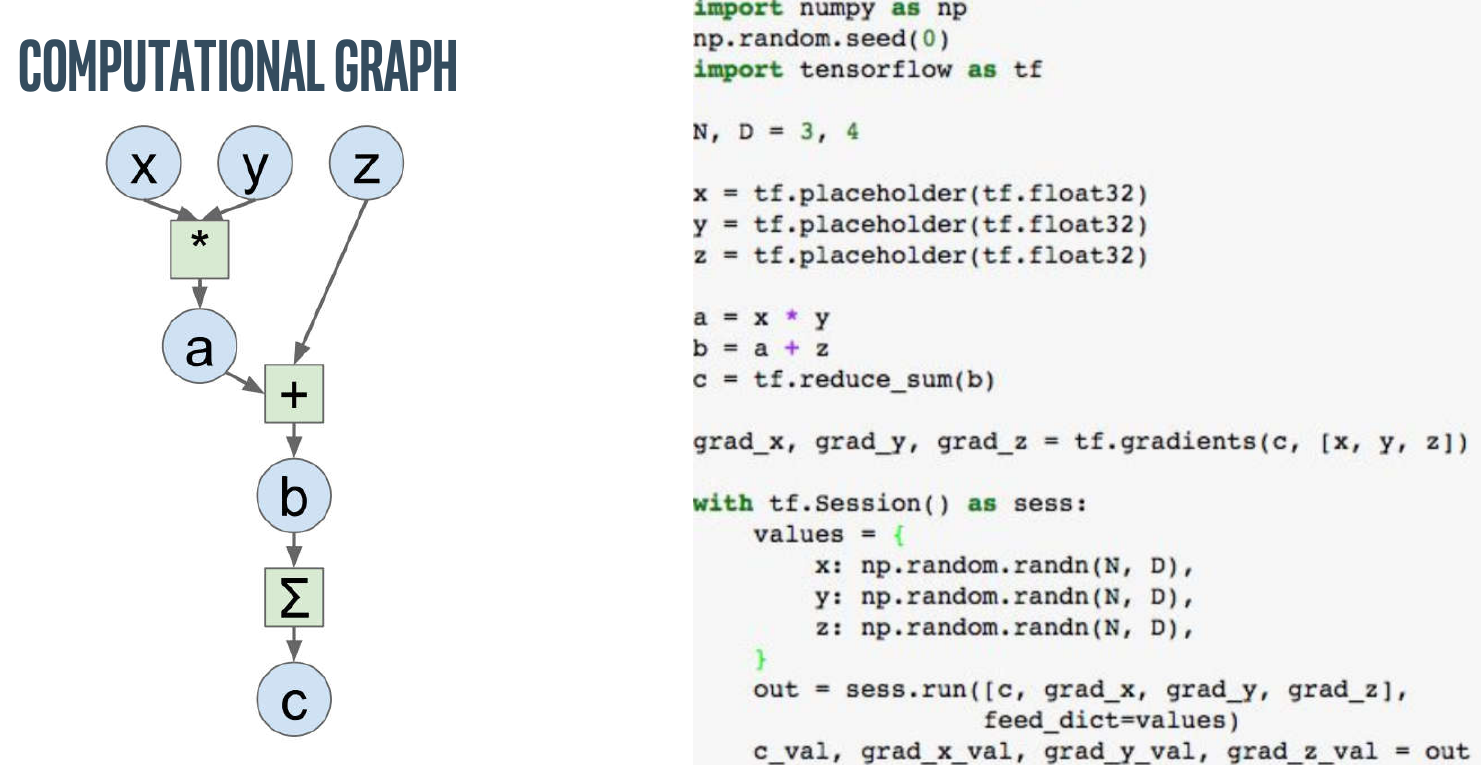

In [ ]:
Image(filename='img/computational_graph.png',width=800)

# Reinforcement learning (Examples)
### Autonomous driving (how much steering to turn, brake pad pressure to apply)
### Decision making in games (which move to play, where to move joystick)
### Investing (which stock to buy, which to sell)
### Deciding about hyperparameters of a deep neural network (automated learning of hyperparameters aka metalearning)

# Reinforcement learning concepts
## Environment and Agent
### Environment: gives observations and rewards
### Agent: takes actions



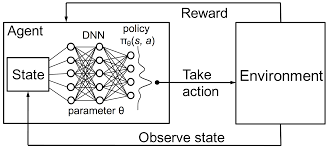

In [6]:
Image(filename='img/state-action-reward.png',width=500)

# Case study: Pong from Pixels

## copied shamelessly from http://karpathy.github.io/2016/05/31/rl/

In [1]:
import gym
import time
from gym.spaces import Discrete
import numpy as np
from scipy.signal import lfilter
from scipy.misc import imsave, imresize
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt

In [2]:
args = {'env': 'Pong-v0', 'batch_size': 10000,'learning_rate':1e-3,'discount':0.99,'hidden_size':20,'gradient_clip':40.0,'value_scale':0.5,'entropy_scale':0,'max_steps':10000}
print args

{'discount': 0.99, 'value_scale': 0.5, 'entropy_scale': 0, 'env': 'Pong-v0', 'learning_rate': 0.001, 'hidden_size': 20, 'gradient_clip': 40.0, 'batch_size': 10000, 'max_steps': 10000}


# Some definitions

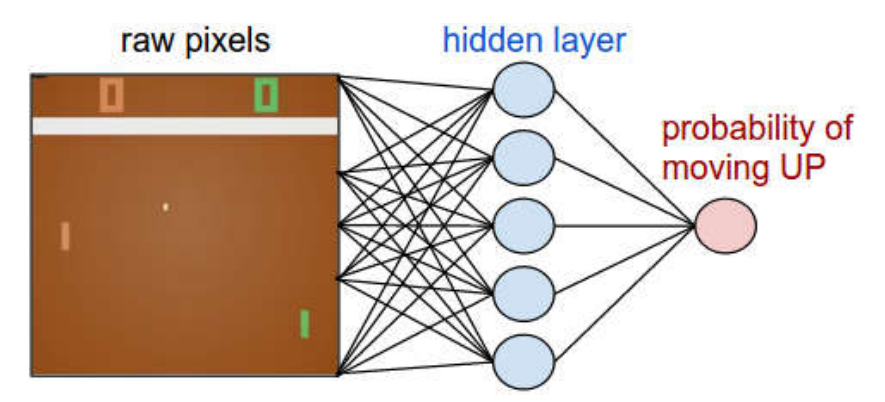

In [10]:
Image(filename='img/pong_pixels.png',width=500)

In [12]:
def process_frame(frame):
    """ Atari specific preprocessing, consistent with DeepMind """
    reshaped_screen = frame.astype(np.float32).mean(2)      # grayscale
    resized_screen = imresize(reshaped_screen, (84, 110)) # downsample
    x = resized_screen[18:102, :]                           # crop top/bottom
    x = imresize(x, (42, 42)).astype(np.float32)                             # downsample
    x *= (1.0 / 255.0)                                      # place in [0,1]
    x = np.reshape(x, [42, 42, 1])                          # introduce channel
    return x

def policy_spec(x):
    net = slim.conv2d(x, args['hidden_size'], [5, 5], stride=2, padding='SAME', activation_fn=tf.nn.elu, scope='conv1')
    net = slim.conv2d(net, args['hidden_size'], [5, 5], stride=2, padding='SAME', activation_fn=tf.nn.elu, scope='conv2')
    net = slim.flatten(net)
    action_logits = slim.fully_connected(net, num_actions, activation_fn=None, scope='fc_act')
    value_function = slim.fully_connected(net, 1, activation_fn=None, scope='fc_value')
    return action_logits, value_function

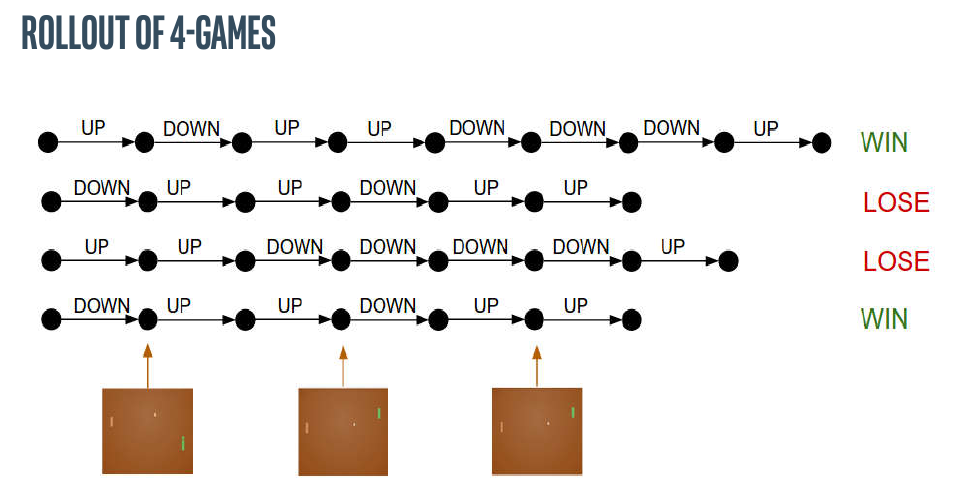

In [13]:
Image(filename='img/rollout.png',width=500)

In [14]:
def rollout(n, max_steps_per_episode=4500):
    """ gather a single episode with current policy """
    # 1. rollout or forward pass
    # 1.1.take a frame, 
    # 1.2 preprocess, 
    # 1.3 pass frame through policy net->action,
    # 1.4 pass action through environment and get [obs, action, rewards, discounted_reward] )

    observations, actions, rewards, discounted_rewards = [], [], [], []
    ob = env.reset()
    ep_steps = 0
    num_episodes = 0
    ep_start_pointer = 0
    prev_obf = None
    while True:

        # we concatenate the previous frame to get some motion information
        obf_now = process_frame(ob)
        obf_before = obf_now if prev_obf is None else prev_obf
        obf = np.concatenate((obf_before, obf_now), axis=2)
        #obf = obf_now - obf_before
        prev_obf = obf_now

        # run the policy
        action = sess.run(action_index, feed_dict={x: np.expand_dims(obf, 0)}) # intro a batch dim
        action = action[0][0] # strip batch and #of samples from tf.multinomial

        # execute the action
        ob, reward, done, info = env.step(action)
        ep_steps += 1

        observations.append(obf)
        actions.append(action)
        rewards.append(reward)

        if done or ep_steps >= max_steps_per_episode:
            num_episodes += 1
            ep_steps = 0
            prev_obf = None
            discounted_rewards.append(discount(rewards[ep_start_pointer:], args['discount']))
            ep_start_pointer = len(rewards)
            ob = env.reset()
            if len(rewards) >= n: break
            
    return np.stack(observations), np.stack(actions), np.stack(rewards), np.concatenate(discounted_rewards), {'num_episodes':num_episodes}

def discount(x, gamma):
    return lfilter([1],[1,-gamma],x[::-1])[::-1]

# Create the Atari environment


In [15]:
env = gym.make(args['env'])
num_actions = env.action_space.n
num_actions

[2017-09-26 13:44:43,672] Making new env: Pong-v0


6

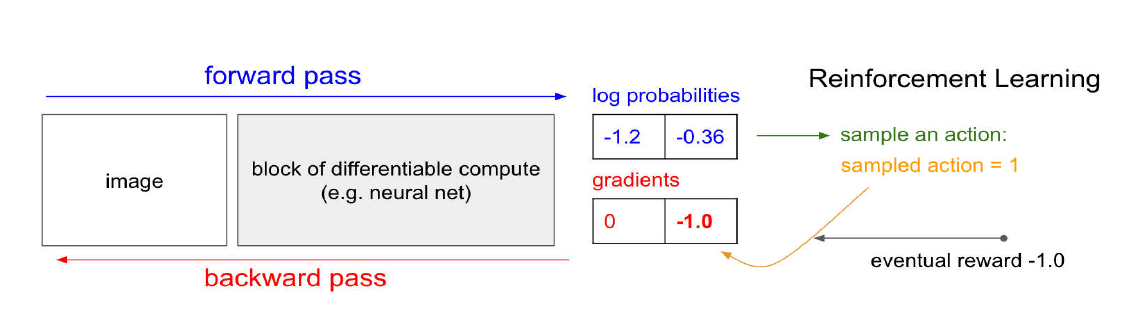

In [16]:
Image(filename='img/rl_training.png',width=800)

# Compile the model

In [17]:
x = tf.placeholder(tf.float32, (None,) + (42,42,2), name='x')
action_logits, value_function = policy_spec(x)
action_index = tf.multinomial(action_logits - tf.reduce_max(action_logits, 1, keep_dims=True), 1) # take 1 sample

# Compile the loss

In [18]:
# 1) the policy gradient
sampled_actions = tf.placeholder(tf.int32, (None,), name='sampled_actions')
discounted_reward = tf.placeholder(tf.float32, (None,), name='discounted_reward')
pg_loss = tf.reduce_mean((discounted_reward - value_function) * tf.nn.sparse_softmax_cross_entropy_with_logits(logits=action_logits, labels=sampled_actions))
# and 2) the baseline (value function) regression piece
value_loss = args['value_scale'] * tf.reduce_mean(tf.square(discounted_reward - value_function))
# and 3) entropy regularization
action_log_prob = tf.nn.log_softmax(action_logits)
entropy_loss = -args['entropy_scale'] * tf.reduce_sum(action_log_prob*tf.exp(action_log_prob))
# add up and minimize
loss = pg_loss + value_loss + entropy_loss

# Create the optimizer

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=args['learning_rate'])
grads = tf.gradients(loss, tf.trainable_variables())
grads, _ = tf.clip_by_global_norm(grads, args['gradient_clip']) # gradient clipping
grads_and_vars = list(zip(grads, tf.trainable_variables()))
train_op = optimizer.apply_gradients(grads_and_vars)

# Forward (Rollouts) and backward (policy updates)

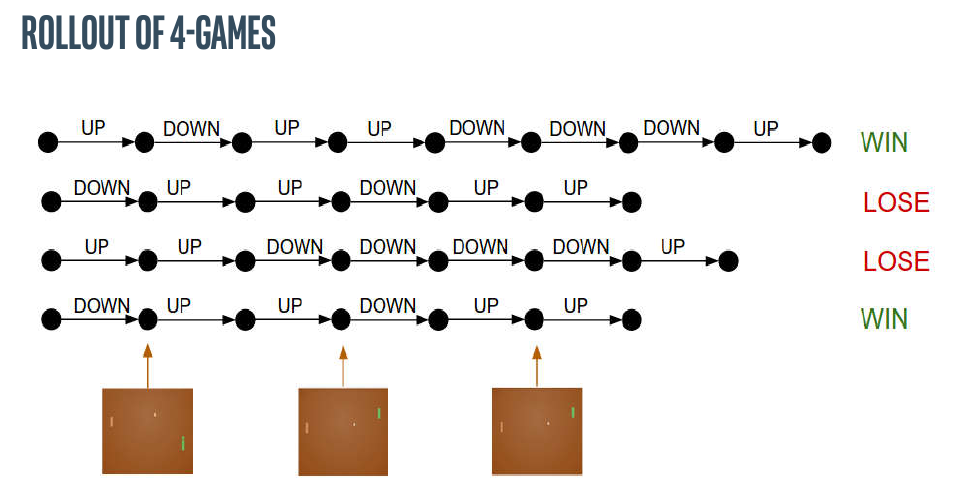

In [20]:
Image(filename='img/rollout.png',width=500)

In [21]:
###
# Sequence of events: 
# 1. rollout or forward pass
    # 1.1.take a frame, 
    # 1.2 preprocess, 
    # 1.3 pass frame through policy net->action,
    # 1.4 pass action through environment and get [obs, action, rewards, discounted_reward] )
# 2. update or backward pass:
    # 2.1 adjust the weights of learned mapping
# tf init
sess = tf.Session()
sess.run(tf.global_variables_initializer())
n = 0
mean_rewards = []
while n <= args['max_steps']: # loop forever
    n += 1

    # collect a batch of data from rollouts 
    t0 = time.time()
    observations, actions, rewards, discounted_reward_np, info = rollout(args['batch_size'])
    print(observations.shape, actions.shape, rewards.shape, info)##
    t1 = time.time()
    # learn the weights
    sess.run(train_op, feed_dict={x:observations, sampled_actions:actions, discounted_reward:discounted_reward_np})
    t2 = time.time()

    average_reward = np.sum(rewards)/info['num_episodes']
    mean_rewards.append(average_reward)
    print('step %d: collected %d frames in %fs, mean episode reward = %f (%d eps), update in %fs' % \
        (n, observations.shape[0], t1-t0, average_reward, info['num_episodes'], t2-t1))

print(args)
print('total average reward: %f +/- %f (min %f, max %f)' % \
      (np.mean(mean_rewards), np.std(mean_rewards), np.min(mean_rewards), np.max(mean_rewards)))

((11042, 42, 42, 2), (11042,), (11042,), {'num_episodes': 9})
step 1: collected 11042 frames in 54.628681s, mean episode reward = -19.888889 (9 eps), update in 10.069863s
((10020, 42, 42, 2), (10020,), (10020,), {'num_episodes': 8})
step 2: collected 10020 frames in 45.308477s, mean episode reward = -20.375000 (8 eps), update in 8.013203s
((10444, 42, 42, 2), (10444,), (10444,), {'num_episodes': 8})
step 3: collected 10444 frames in 55.366946s, mean episode reward = -19.875000 (8 eps), update in 9.328800s
((10854, 42, 42, 2), (10854,), (10854,), {'num_episodes': 9})
step 4: collected 10854 frames in 53.125024s, mean episode reward = -20.444444 (9 eps), update in 10.023498s
((10262, 42, 42, 2), (10262,), (10262,), {'num_episodes': 8})
step 5: collected 10262 frames in 54.880147s, mean episode reward = -20.375000 (8 eps), update in 8.694345s
((10785, 42, 42, 2), (10785,), (10785,), {'num_episodes': 10})
step 6: collected 10785 frames in 54.220478s, mean episode reward = -20.800000 (10 ep

KeyboardInterrupt: 

# A Close look at observations, actions, rewards

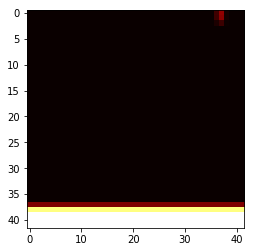

In [24]:
frame=12
a0=np.array(observations[frame,:,:,0])
a1=np.array(observations[frame,:,:,1])
plt.imshow(a0, cmap='hot', interpolation='nearest')
plt.show()

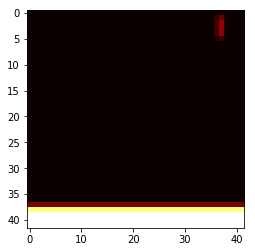

In [25]:
plt.imshow(a1, cmap='hot', interpolation='nearest')
plt.show()

In [26]:
b=actions
b

array([0, 2, 0, ..., 4, 0, 0])

In [27]:
c=rewards
c

array([ 0.,  0.,  0., ...,  0.,  0., -1.])

In [28]:
d=discounted_reward_np
d

array([-1.10482069, -1.11598049, -1.12725302, ..., -0.9801    ,
       -0.99      , -1.        ])

In [29]:
info

{'num_episodes': 10}

In [30]:
train_op

<tf.Operation 'Adam' type=NoOp>